Notebook to test new distance, angle and force calculations

In [271]:
#%% import libraries
# generic
import sys
import numpy as np
import os,glob # for listing files in folder
import re # regular expressions
import pandas as pd
import scipy
import seaborn
import math as m
from scipy.signal import savgol_filter
from scipy.spatial import distance as sci_distance
from scipy.stats import kruskal
import importlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import random
import itertools
from tqdm.notebook import tqdm

# new variable calculations
import exp2funcs_2025
import exp2funcs
# sys.path.append('..')
import useful_functions as uf 

#general parameters
cmap = plt.get_cmap('viridis')
# fs = 16 # standard font size for plots

# unit conversion for paper figures
dyne2mN = 1/100
mg2mN = 1/100
mg2uN = 1*10
print(os.getcwd())

importlib.reload(uf)
importlib.reload(exp2funcs_2025)

save_folder = r'C:\Users\Amir\Documents\PHD\Thesis\My Articles\0 - Flexible dynamic force measurement method via physical pendulum\Images'

c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0
hi


In [3]:
#%% import data 
root_path = r'C:\Users\Amir\Documents\PHD\Experiments\Force Measurements'
basepath = root_path+r'\Exp2_Pendulum' # pendulum exp folder
excel= r'\Exp2_supplementary_measurements_events.csv'

# straw exp data
data_panda = pd.read_csv(basepath+excel)


# import tracked data, initiate variables
track_sup_path = r'\track_logs'
track_folder_path = basepath+track_sup_path

track_contact_path = r'\contact_track_logs'
contact_folder_path = basepath+track_contact_path

track_near_sup_path = r'\twine_init_logs'
track_near_sup_folder_path = basepath+track_near_sup_path

h5_path = r'\Measurements\root_stem_results'
h5_folder_path = basepath+h5_path

E_path = r'\Young_moduli'
E_folder_path = basepath+E_path

N_track = len(os.listdir(track_folder_path)) # get number of files in track folder
N_contact=len(os.listdir(contact_folder_path)) # get number of files in contact folder
N_tot = len(data_panda) # get number of lines in excel
N_E = len(os.listdir(E_folder_path))


#%% remove problematic events from raw data
delete_rows = [] # save rows to delete
problem_exp = [] # exp_num of problem events

for i in range(N_tot): # remove problem events and non-Helda events
    if data_panda.at[i,'problem']!='na' or data_panda.at[i,'Bean_Strain']!='Helda':
        delete_rows.append(i)
        problem_exp.append(data_panda.at[i,'Exp_num'])
N = N_tot - len(delete_rows) # modify num of rows

data_panda = data_panda.drop(data_panda.index[delete_rows]) # remove prob. events
data_panda = data_panda.reset_index() # redo index
#%% get misc. file lists

# get track files for support bottom coordinates
remove_chars = re.compile('[,_\.!?]') # what to remove from strings
track_dict = {} # save support track in dictionary by exp and events
i=0 # start with first track file
for file in glob.glob(os.path.join(track_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('[0-9]',re.findall('_\d{1}\D',file)[0].replace('_',''))[0]) # find event number
    viewt = re.findall('(side{1}|top{1})',file)[0] #.replace('_','')
    track_dict[(exp,event,viewt)] = [file] # add new exp
    i+=1

# get track files for stem-support contact coordinates
contact_dict = {} # save support contact track in dictionary by exp and events
i=0 # start with first contact file
for file in glob.glob(os.path.join(contact_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
    contact_dict[(exp,event)] = [file] # add new exp
    i+=1

# get track files for 2 stem positions on either side of support
near_sup_track_dict = {}
i=0 # start with first stem_near_sup file
for file in glob.glob(os.path.join(track_near_sup_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
    near_sup_track_dict[(exp,event)] = [file] # add new exp
    i+=1

# get h5 files for stem near support
h5_dict = {}
i=0 # start with first h5 file
for file in glob.glob(os.path.join(h5_folder_path, '*.h5')): # for each event:
    exp = int(re.findall('interekt_\d{2,3}_',file)[0].split('_')[1]) # find exp number (3-4 digits)
    event = int(re.findall('e_[0-9]_',file)[0].split('_')[1]) # find event number
    start_frame = int(re.findall('_\d{2,5}-\d{2,5}',file)[0].replace('_','').split('-')[0]) # find start frame
    h5_dict[(exp,event,start_frame)] = [file] # add new exp
    i+=1

# get Young modulus files
E_dict = {}
for file in glob.glob(os.path.join(E_folder_path, '*.csv')):
    exp = int(re.findall('\d{2,3}',file)[0])
    E_dict[exp]=pd.read_csv(file,header=None)

#%%

In [ ]:
#%% clear plants and events
plants = []
events = []
#%% populate plant and event instances
i = 0
N = len(data_panda)

for i in tqdm(range(N), leave=True): 
    try:
        exp = int(re.findall('\d{3,4}',data_panda.at[i,'Exp_num'])[0]) # exp num
        view = data_panda.at[i,'View']  # side of top view
        if view == 'top':
            plants[-1].pix2cm_t = float(data_panda.at[i,'Top_pix2cm'])

        if i==0 or exp!=plants[-1].exp_num: # append new plant with data from pandas
            #basic data
            plants.append(exp2funcs_2025.Plant(data_panda,basepath,i,exp))
            # plants.append(exp2funcs.Plant(data_panda,basepath,i,exp))
            # view dependent data
            plants[-1].view_data(data_panda,i)
            # circumnutation data
            plants[-1].cn_data(data_panda,i)
            #Youngs modulus by segment with avg
            plants[-1].getE(E_dict)


        event =  int(re.findall('_[0-9]',data_panda.at[i,
        'Exp_num'])[0].replace('_','')) # get event number


        # if this is the 1st event or the previous event_num is different from the current one:
        # add new event to list
        if len(events)==0 or events[-1].event_num != event or \
            events[-1].p.exp_num != exp:
            events.append(exp2funcs_2025.Event(plants[-1],data_panda,i))
            # events.append(exp2funcs.Event(plants[-1],data_panda,i))

        events[-1].event_num = event

        # view dependent data
        events[-1].view_data(data_panda,i,view)

        # get automated extraction of twine(decision) time
        events[-1].get_twine_time(exp,event,view,
                        h5_dict,near_sup_track_dict,50,track_dict,to_plot=0)


        # get track data, select decision period data, pix2cm,
        events[-1].event_base_calcs(view,track_dict,contact_dict)
        # calc
        events[-1].event_calc_variables(view)
            # print(f'i={i}, exp number {exp}, {event}') # print progress
    except Exception as e:
        print(f'Error at i={i}, exp number {exp}, {event}')
        print(e)
        continue

  0%|          | 0/264 [00:00<?, ?it/s]

c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\exp2funcs_2025.py:355: RuntimeWarning: divide by zero encountered in divide
  self.L_contact2suptip2 = self.p.Lsup_cm - self.r_c/np.sin(self.alpha)
c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\exp2funcs_2025.py:515: RuntimeWarning: divide by zero encountered in scalar divide
  # dFvec[i]=calc_dF(d_contact[i], dd_contact, l_sup_cm, dm_sup, phi[i], dphi[i], m_sup, dm_sup)


Slip:True


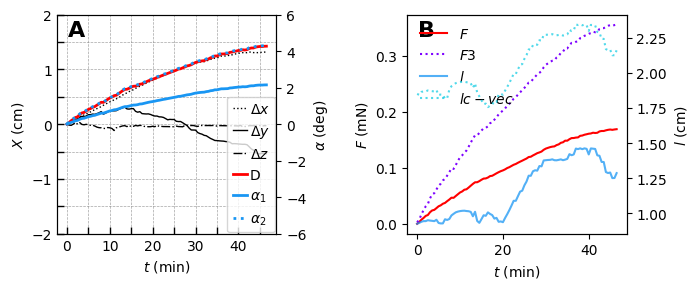

In [310]:
#%% figure - Force trajectory for slip event with contact position along support 2
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('rainbow')
fs= 16
i_slip = 40 # 40 (simple) , 20,120 (bump from dist2tip) , 70 = 79_2
test_ev = events[i_slip]
# check events are correctly classified
print("Slip:"+ str( test_ev.twine_state==0))

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
# add subplot labels
axs[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=axs[1].transAxes)

# Plot xyz coordinates
xyz = test_ev.xyz
axs[0].plot(test_ev.timer/60, xyz[0,::]-xyz[0,0], color='black', 
            linestyle = 'dotted', linewidth = 1, label=r'$\Delta x$') #cmap(0.1)
axs[0].plot(test_ev.timer/60, xyz[1,::]-xyz[1,0], color='black', 
            linestyle = '-', linewidth = 1, label=r'$\Delta y$') #cmap(0.5)
axs[0].plot(test_ev.timer/60, xyz[2,::]-xyz[2,0], color='black', 
            linestyle = 'dashdot', linewidth = 1, label=r'$\Delta z$') #cmap(0.9)
axs[0].plot(test_ev.timer/60, test_ev.trk_dist, color=cmap(1.5), linewidth = 2, label = 'D') #cmap(1.5)

# Plot angle on the same figure with different axis
axs0 = axs[0].twinx()
axs0.plot(test_ev.timer/60, np.rad2deg(test_ev.alpha), 
          color=cmap(0.2), linewidth = 2, label=r'$\alpha_1$') #cmap(0.2)
axs0.plot(test_ev.timer/60, np.rad2deg(test_ev.alpha2), 
          color=cmap(0.2),linestyle = 'dotted', linewidth = 2, label=r'$\alpha_2$') #cmap(0.3)

# add legend label from the twin axis
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = axs0.get_legend_handles_labels()

# set axis and grid
axs[0].set_xlabel(r'$t$ (min)')
axs[0].set_ylabel(r'$X$ (cm)')
axs[0].set_ylim([-2,2])
axs0.set_ylim([-6,6])
uf.set_grid(axs[0],50,5)
# axs0.set_xlabel(r'$t$ (min)')
axs0.set_ylabel(r'$\alpha$ (deg)')

# Adjust the legend properties

axs[0].legend(
    lines + lines2, labels + labels2,
    loc='lower right',          # Place legend
    frameon=True,              # Remove the frame
    handlelength=1,             # Shorter line elements
    handletextpad=0.2,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=10                 # Smaller font size for better fit
)


###########################################
# Plot calculated force and contact position

axs[1].plot(test_ev.timer/60, test_ev.F_bean,
             color=cmap(1.5), label=r'$F$') #cmap(0.2)
# axs[1].plot(test_ev.timer/60, test_ev.F_bean_2,
#              color=cmap(1.55),linestyle = 'dashed', label=r'$F2$') #cmap(0.2)
axs[1].plot(test_ev.timer/60, test_ev.F_bean_3,
             color=cmap(1),linestyle = 'dotted', label=r'$F3$') #cmap(0.2)

ax2 = axs[1].twinx()
dist2tip = [abs(k) for k in test_ev.L_contact2suptip]
lc_trig = [abs(k) for k in test_ev.l_c_trig]
lc_vec = [abs(k) for k in test_ev.l_c_vec]

# axs[1].vlines(test_ev.timer[-1]/60, 0, test_ev.F_bean[-1]*mg2mN,
#                color=cmap(1.5),)
ax2.plot(test_ev.timer/60, dist2tip, color= cmap(0.2),
          label=r'$l$', alpha=0.75)
# ax2.plot(test_ev.timer/60, lc_trig, color= cmap(0.25), linestyle='dashed',
#           label=r'$lc-trig$', alpha=0.75)
ax2.plot(test_ev.timer/60, test_ev.p.Lsup_cm-lc_vec, color= cmap(0.3), linestyle='dotted',
          label=r'$lc-vec$', alpha=0.75)

lines, labels = axs[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[1].legend(lines + lines2, labels + labels2, loc='best',frameon=False)

ax2.set_ylabel(r'$l$ (cm)')
# ax2.set_ylim([0,2])
axs[1].set_xlabel(r'$t$ (min)')
axs[1].set_ylabel(r'$F$ (mN)')
# uf.set_grid(axs[1],50,0.15)

plt.tight_layout()
plt.show()
# fig.savefig(save_folder+r'\xyz_ang_F_l_2.png',dpi=300)

In [311]:

# plt.plot(test_ev.alpha2)
# plt.plot(test_ev.l_c_trig)
# plt.plot(test_ev.l_c_vec,'r')
# plt.plot(test_ev.xyz_contact[2])
# plt.plot(np.sqrt(test_ev.xyz_contact[0]**2+test_ev.xyz_contact[1]**2+test_ev.xyz_contact[2]**2))
print(test_ev.p.exp_num,test_ev.event_num)
# plt.plot(test_ev.dxyz[2],'b')
# plt.plot(test_ev.xyz[2],'b')
# plt.plot(test_ev.dz_cont,'r')
# print(test_ev.F_bean_3)
# plt.plot(test_ev.pz)
# plt.plot(test_ev.z_cont_dec)
# plt.plot(test_ev.z_cont)
# print(f'lengths of variables: {len(test_ev.pz)},{len(test_ev.dz_cont)},{len(test_ev.F_bean_3)},\
#       {len(test_ev.alpha2)},{len(test_ev.l_c_vec)}')
# plt.plot(test_ev.p.Lsup_cm,'x')
# plt.plot(test_ev.p.m_sup,'x')
# plt.plot(test_ev.z_cont_dec-test_ev.p.Lsup_cm)
# plt.plot(test_ev.xyz_contact[2])
# plt.plot(np.subtract(test_ev.xyz.T,test_ev.hinge).T[2])
print(f'{test_ev.z0_side=},{test_ev.p.support_base_z_pos_pix=}')
print(f'{test_ev.p.pix2cm_s=}')

print(f'{test_ev.L_tracked=},{test_ev.L_track2suptip_cm=}')


54 3
test_ev.z0_side=2427.0,test_ev.p.support_base_z_pos_pix=2507.0
test_ev.p.pix2cm_s=0.011574074
test_ev.L_tracked=18.974073952639998,test_ev.L_track2suptip_cm=0.9259259200000001
